# For defining reaction templates used in polymer fragment generation

# Core Imports

In [1]:
# Custom Imports
from polymerist.rdutils import rdkdraw
from polymerist.rdutils.reactions import reactions
from polymerist.rdutils.bonding import portlib

from polymerist.smileslib.functgroups import FN_GROUP_TABLE
from polymerist.monomers import specification

# File I/O
import json
from collections import defaultdict
from pathlib import Path

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

# Static Paths
# RXN_FILES_PATH = Path('rxn_smarts')
RXN_FILES_PATH = Path('poly_rxns')
RXN_FILES_PATH.mkdir(exist_ok=True)

## Defining target functional groups

### Define functional groups (with R-group linkers) as basis for desired reactions

phthalimide


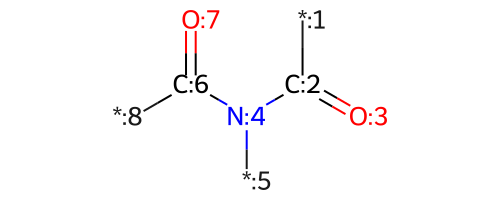

carbamate


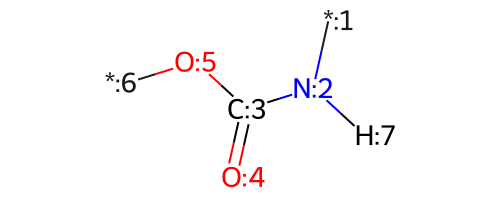

cyclocarbonate


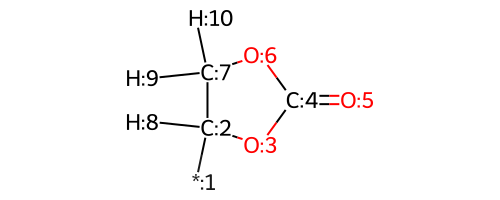

anhydride


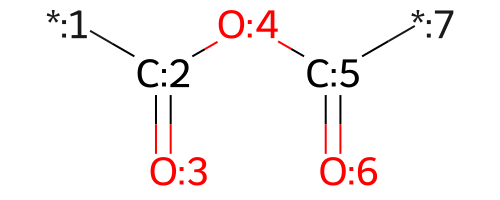

vinyl


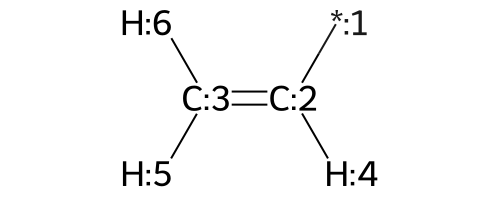

terminal_alkene


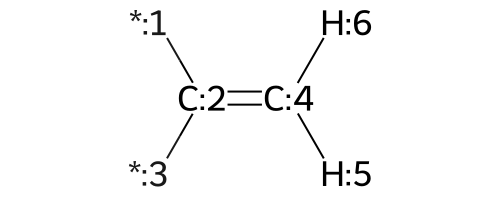

acyl_chloride


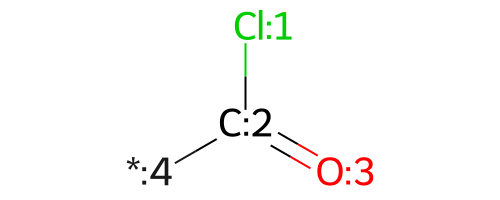

carboxyl


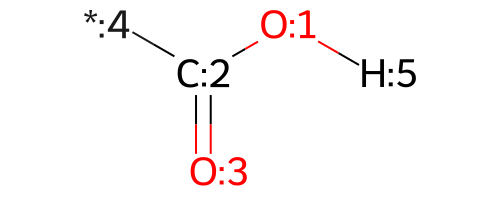

ester


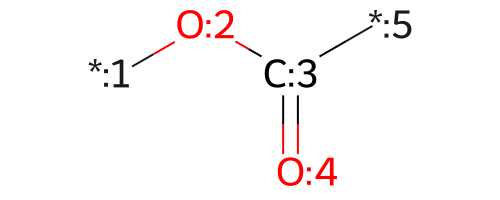

amine


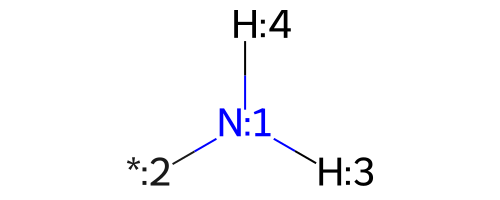

hydroxyl


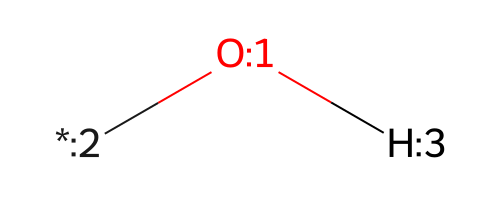

isocyanate


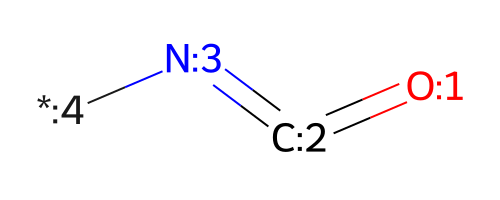

In [2]:
rdkdraw.set_rdkdraw_size(200, 5/2)

fn_group_smarts_bare = { # TODO : add specificity vis-a-vis bond degree and stereo
    'phthalimide'    : '*C(=O)N(*)C(=O)*',
    'carbamate'      : '*[NH]C(=O)O*',
    # 'cyclocarbonate' : '*C1OC(=O)OC1*',
    'cyclocarbonate' : '*C1OC(=O)OC1',
    'anhydride'      : '*C(=O)OC(=O)*',
    'vinyl'          : '*C=C',
    'terminal_alkene': '*C(-*)=C',
    'acyl_chloride'  : 'Cl-C(=O)*',
    'carboxyl'       : 'OC(=O)*',
    'ester'          : '*OC(=O)*',
    'amine'          : '[NH2]*',
    'hydroxyl'       : '[OH]*',
    'isocyanate'     : 'O=C=N*',
}

fn_group_smarts, fn_groups = {}, {}
for group_name, smiles in fn_group_smarts_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=True)
    fn_group_mol = Chem.MolFromSmiles(exp_smiles, sanitize=False)
    fn_group_mol.SetProp('_Name', group_name) # shows up as MDL mol label in file

    for atom in fn_group_mol.GetAtoms():
        if portlib.is_linker(atom):
            atom.SetProp('molFileValue', group_name)
            break # ensure this is only set once
    
    print(group_name)
    display(fn_group_mol)

    fn_group_smarts[group_name] = exp_smiles
    fn_groups[      group_name] = fn_group_mol

### Define complete small-molecule byproducts (as query mols)

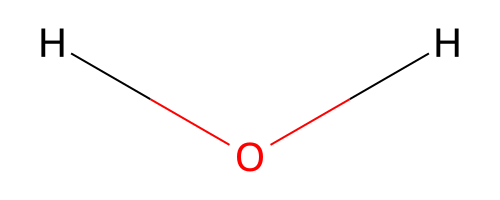

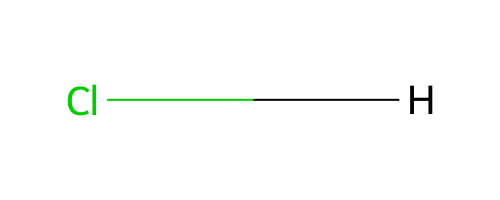

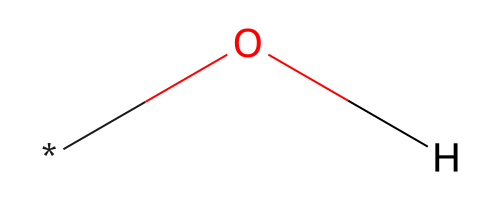

In [3]:
byproduct_smarts_bare = {
    'water' : 'O',
    'hcl'   : '[ClH]',
    'alcohol' : 'O*'
}

byproduct_smarts, byproducts = {}, {}
for group_name, smiles in byproduct_smarts_bare.items():
    exp_smiles = specification.expanded_SMILES(smiles, assign_map_nums=False)
    byproduct = Chem.MolFromSmarts(exp_smiles) # must be SMARTS for successful query

    byproduct_smarts[group_name] = exp_smiles
    byproducts[group_name] = byproduct
    display(byproduct)

## Export functional group and byproduct smiles to files

In [4]:
with (RXN_FILES_PATH / 'fn_group_smarts.json').open('w') as file:
    json.dump(fn_group_smarts, file, indent=4)

with (RXN_FILES_PATH / 'byprod_smarts.json').open('w') as file:
    json.dump(byproduct_smarts, file, indent=4)

# Defining polymerization reactions

In [5]:
from polymerist.rdutils.reactions.assembly import ReactionAssembler

rdkdraw.set_rdkdraw_size(400, 3/2)
portlib.Port.bondable_flavors.insert((1, 2)) # allows for specificity when re-bonding cleaved groups


mechanisms : dict[str, ReactionAssembler] = {
    'polyester' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polyamide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['carboxyl'],
        ),
        bond_derangement= {
            1 : (3, 6),
            5 : (6, 3)
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polyimide' : ReactionAssembler(
        reactive_groups=(
            fn_groups['amine'],
            fn_groups['anhydride'],
        ),
        bond_derangement={
            4 : (1, 8),
            6 : (8, 1),
            3 : (1, 8), # doubles up carbonyl transfer - must have target atoms as beginning to maintain canonical derangement form
            9 : (8, 1),
        },
        byproducts=(
            byproducts['water'],
        )
    ),
    'polycarbonate_phosgene' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['acyl_chloride'],
        ),
        bond_derangement= {
            1 : (3, 5),
            4 : (5, 3)
        },
        byproducts=(
            byproducts['hcl'],
        )
    ),
    'polycarbonate_nonphosgene' : ReactionAssembler(
        reactive_groups=(
            fn_groups['hydroxyl'],
            fn_groups['ester'],
        ),
        bond_derangement= {
            5 : (6, 3),
            1 : (3, 6)
        },
        # bond_derangement= { # technically would give desired end products but is...
        #     4 : (5, 1), # ... inconsistent w/ mechanism of action (relative to phosgene route)...
        #     2 : (1, 5)  # ...AND prohibited by the Port spec (would produce 2 neutronium fragments which are unbondable)
        # },
        byproducts=(
            byproducts['alcohol'],
        )
    ),
    'polyurethane_isocyanate' : ReactionAssembler(
        reactive_groups=(
            fn_groups['isocyanate'],
            fn_groups['hydroxyl'],
        ),
        bond_derangement={
            7 : (5, 3),
            2 : (3, 5)
        }
    ),
    'polyurethane_nonisocyanate' : ReactionAssembler(
        reactive_groups=(
            fn_groups['cyclocarbonate'],
            fn_groups['amine'],
        ),
        bond_derangement= {
            5  : (4, 11), # (7, 11)
            13 : (11, 4)  # (11, 7)
        }
    ),
    'polyvinyl_head_tail' : ReactionAssembler(
        reactive_groups=(
            fn_groups['terminal_alkene'],
            fn_groups['vinyl'],
        ),
        bond_derangement= {
            4  : (2, 8),
            12 : (8, 2)
        }
    ),
}

polyester {1: (3, 5), 4: (5, 3)}


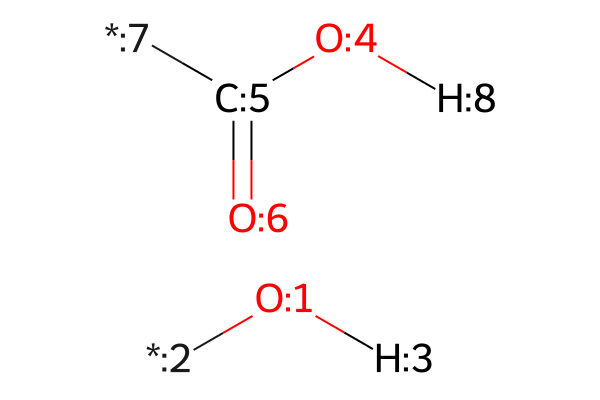

polyamide {1: (3, 6), 5: (6, 3)}


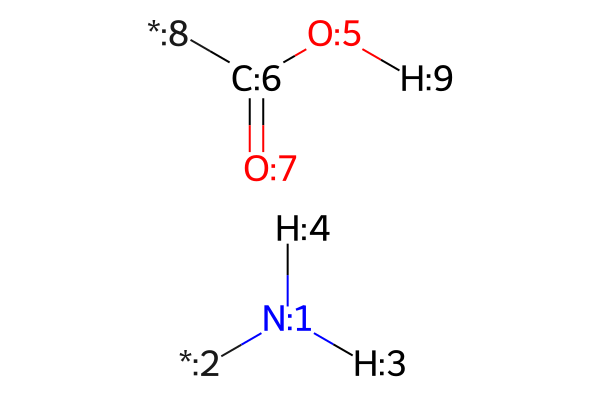

polyimide {4: (1, 8), 6: (8, 1), 3: (1, 8), 9: (8, 1)}


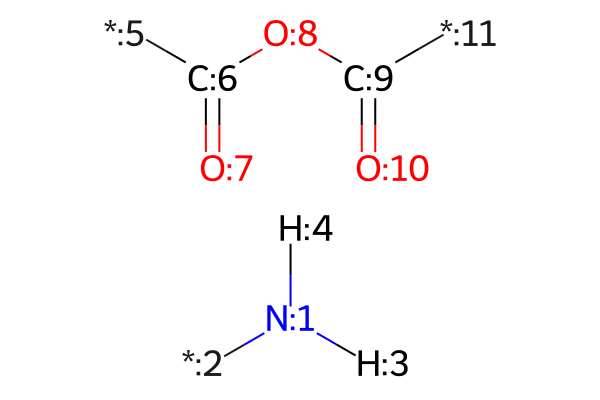

polycarbonate_phosgene {1: (3, 5), 4: (5, 3)}


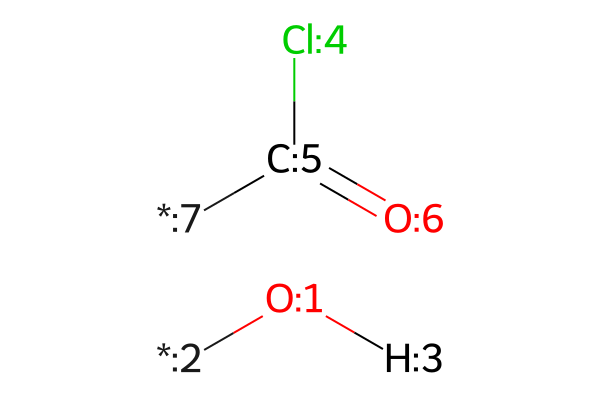

polycarbonate_nonphosgene {5: (6, 3), 1: (3, 6)}


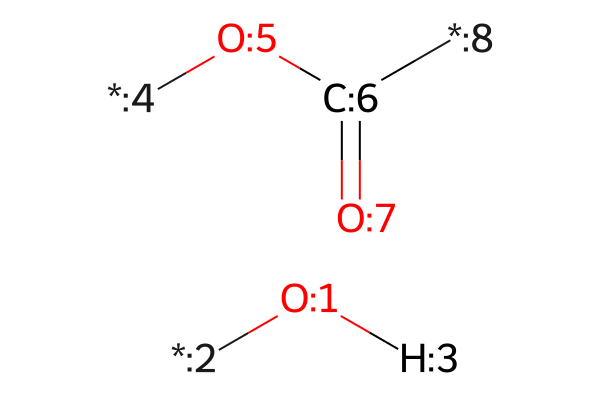

polyurethane_isocyanate {7: (5, 3), 2: (3, 5)}


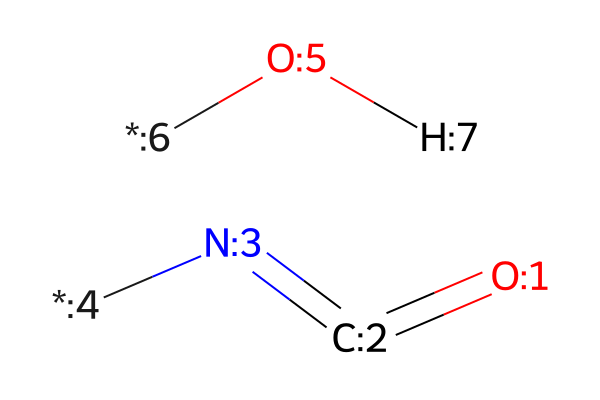

polyurethane_nonisocyanate {5: (4, 11), 13: (11, 4)}


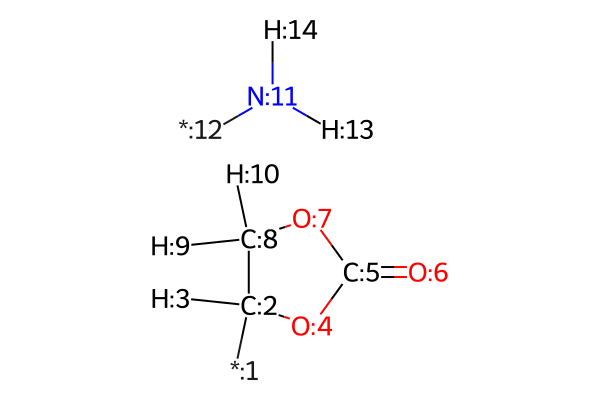

polyvinyl_head_tail {4: (2, 8), 12: (8, 2)}


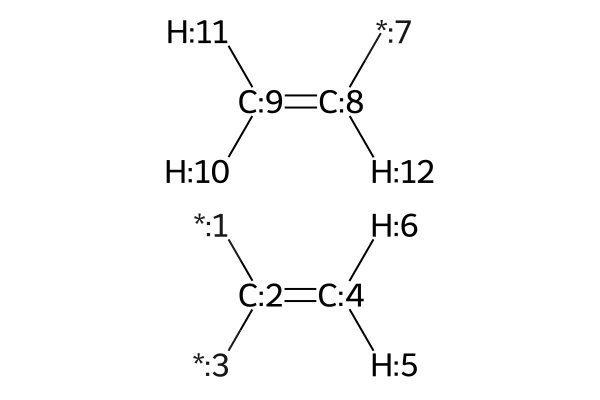

In [6]:
# display mechanism schemata prior to generating reactions (allows for inspection of derangement IDs)
for mech_name, mech_schema in mechanisms.items():
    print(mech_name, mech_schema.bond_derangement)
    display(mech_schema.reactants)

## Generating rxn MDL templates and SMARTS equations and saving to file

polyester


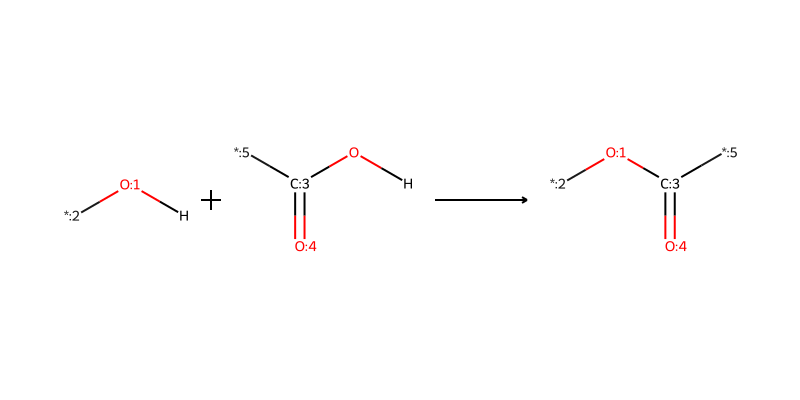

	Reactant match with hydroxyl
	Reactant match with carboxyl
polyamide


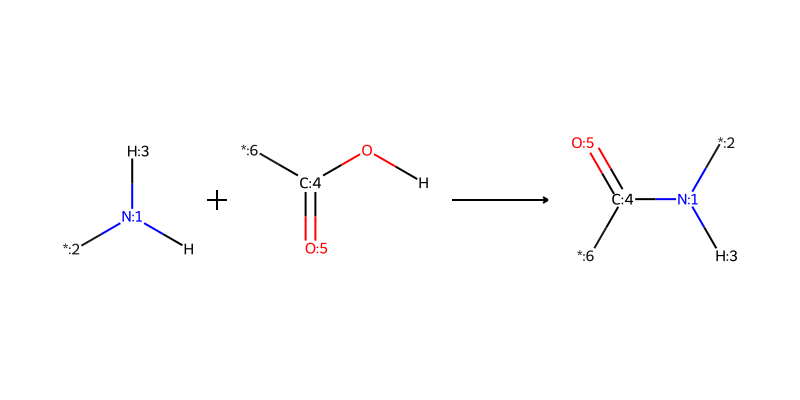

	Reactant match with amine
	Reactant match with carboxyl
polyimide


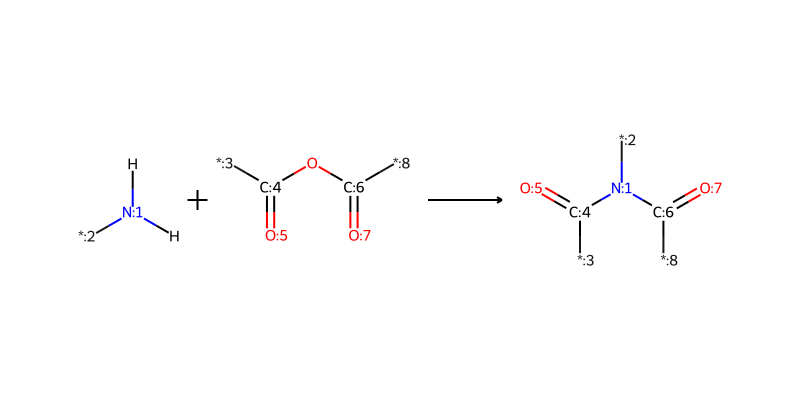

	Reactant match with amine
	Reactant match with anhydride
polycarbonate_phosgene


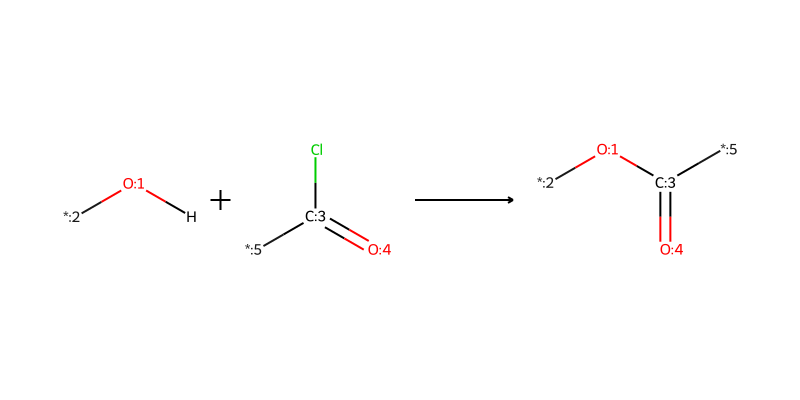

	Reactant match with hydroxyl
	Reactant match with acyl_chloride
polycarbonate_nonphosgene


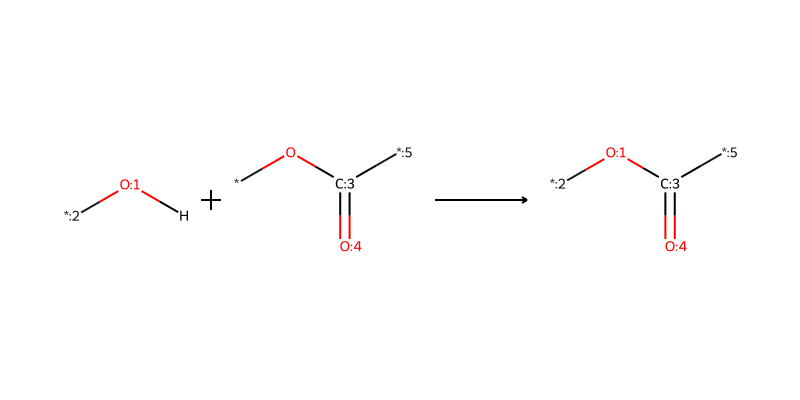

	Reactant match with hydroxyl
	Reactant match with ester
polyurethane_isocyanate


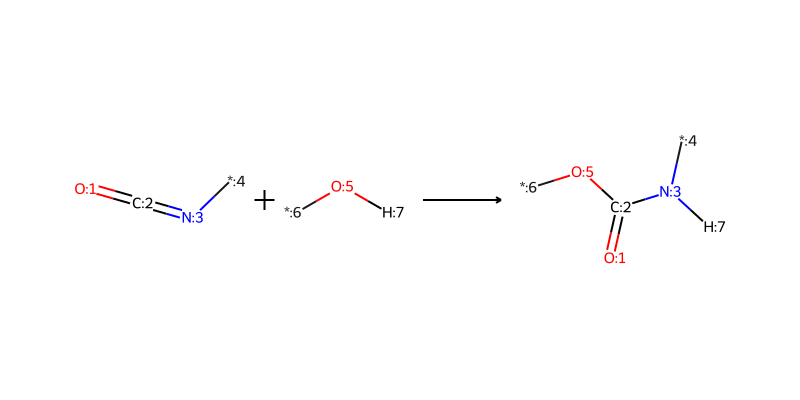

	Reactant match with isocyanate
	Reactant match with hydroxyl
polyurethane_nonisocyanate


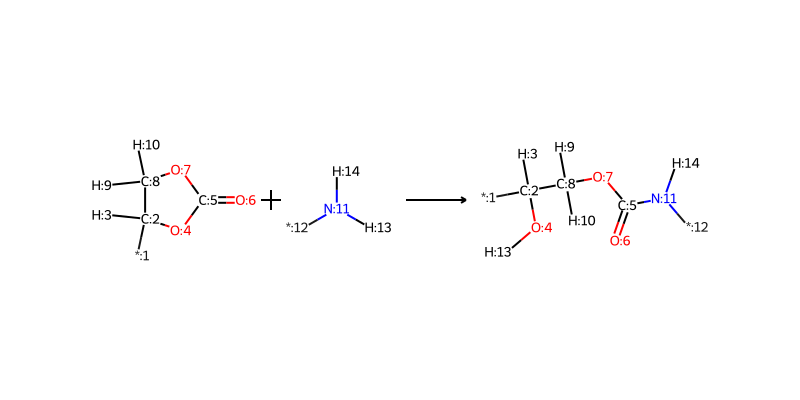

	Reactant match with cyclocarbonate
	Reactant match with amine
polyvinyl_head_tail


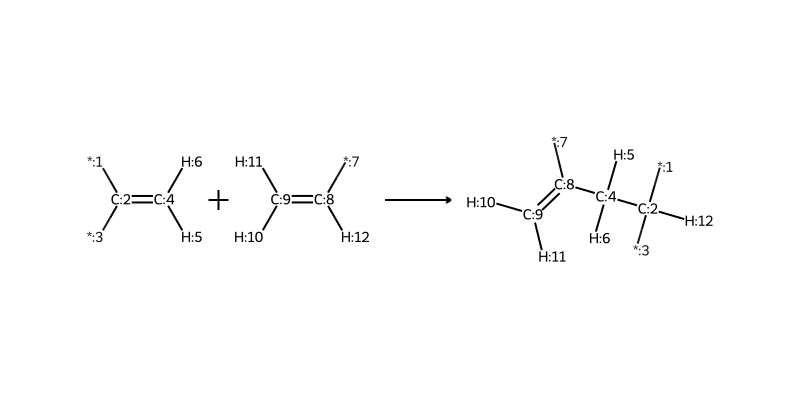

	Reactant match with terminal_alkene
	Reactant match with vinyl


In [7]:
rxns : dict[str, reactions.AnnotatedReaction] = {} 
rxn_smarts : dict[str, str] = {} 
rxn_groups = defaultdict(list)

for mech_name, mech_schema in mechanisms.items():
    # assemble reaction
    print(mech_name)
    rxn = mech_schema.assemble_rxn(show_steps=False)
    rxn.rxnname = mech_name # store mechanism name for reference
    display(rxn)

    # add functional group names to reactants (can't be done prior due to CombineMols() calls)
    for template in rxn.GetReactants():
        for group_name, fn_group in fn_groups.items():
            if template.HasSubstructMatch(fn_group):
                template.SetProp('_Name', group_name)
                rxn_groups[mech_name].append(group_name)
                print(f'\tReactant match with {group_name}')

    rxns[mech_name] = rxn
    rxn_smarts[mech_name] = rdChemReactions.ReactionToSmarts(rxn)

In [8]:
with (RXN_FILES_PATH / 'rxn_smarts.json').open('w') as file:
    json.dump(rxn_smarts, file, indent=4)

with (RXN_FILES_PATH / 'rxn_groups.json').open('w') as file:
    json.dump(rxn_groups, file, indent=4)

for chemistry, rxn in rxns.items():
    rxn.to_rxnfile(RXN_FILES_PATH / f'{chemistry}.rxn', wilds_to_R_groups=True)

# Testing that reaction actually behave as intended

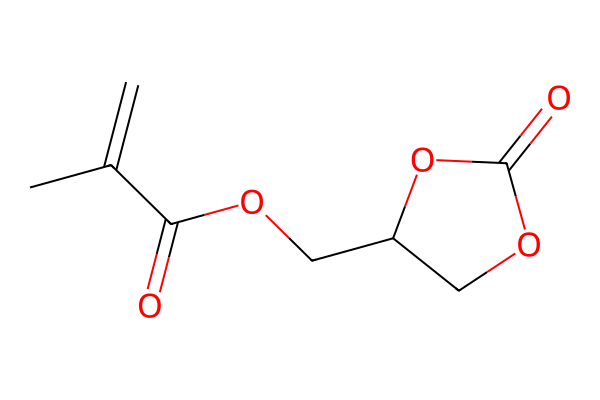

In [9]:
smiles = 'CC(=C)C(=O)OCC1COC(=O)O1'
mol = Chem.MolFromSmiles(smiles, sanitize=False) 
display(mol)

In [18]:
test_reactants = {
    'polyester'                 : ('OCCO', 'O(C=O)c1ccc(cc1)C(=O)O'), # PET
    'polyamide'                 : ('NCCCCCCN', 'O=C(O)CCCCC(=O)O'), # Nylon-6,6
    'polyimide'                 : ('O(c1ccc(N)cc1)c2ccc(cc2)N', 'C1=C2C(=CC3=C1C(=O)OC3=O)C(=O)OC2=O'), # DuPont Kapton (poly (4,4'-oxydiphenylene-pyromellitimide))
    'polycarbonate_phosgene'    : ('Oc1ccc(cc1)C(c2ccc(O)cc2)(C)C', 'ClC(=O)Cl'), # BPA + phosgene
    'polycarbonate_nonphosgene' : ('Oc1ccc(cc1)C(c2ccc(O)cc2)(C)C', 'O=C(Oc1ccccc1)Oc2ccccc2'), # BPA + diphenyl carbonate
    'polyurethane_nonisocyanate': ('CC(=C)C(=O)OCC1COC(=O)O1', 'NCCCCCCN'), # PCA (propylene carbonate acrylate) + hexamethylenediamine
    'polyurethane_isocyanate'   : ('O=C=N\CCCCCC/N=C=O', 'OCCCCO'), # Bayer HDI + BDO
    'polyvinyl_head_tail'       : ('c1ccccc1C=C', 'c1ccccc1C=C'), # polystyrene
}

# convert to explicit expanded SMILES
test_reactants = {
    rxn_name : tuple(specification.expanded_SMILES(smi, assign_map_nums=False) for smi in reactant_smiles)
        for rxn_name, reactant_smiles in test_reactants.items()
}

with (RXN_FILES_PATH / 'test_reactants.json').open('w') as file:
    json.dump(test_reactants, file, indent=4)

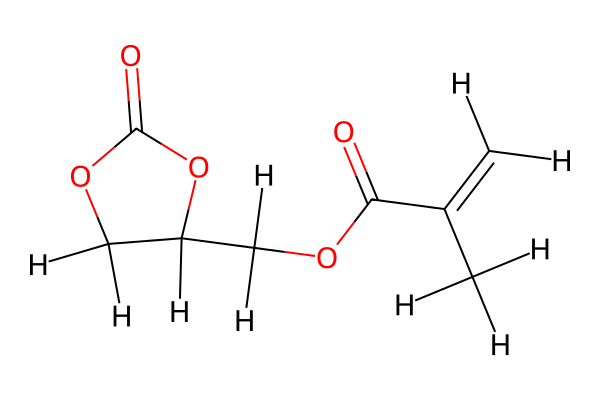

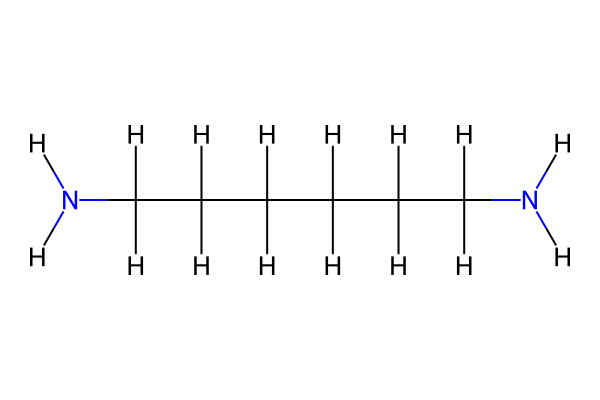

In [19]:
# targ_rxn = 'polycarbonate_nonphosgene'
targ_rxn = 'polyurethane_nonisocyanate'
# targ_rxn = 'polyimide'
# targ_rxn = 'polyamide'

reactants = []        
for smi in test_reactants[targ_rxn]:
    reactant = Chem.MolFromSmiles(smi, sanitize=False)
    display(reactant)
    reactants.append(reactant)

0 0


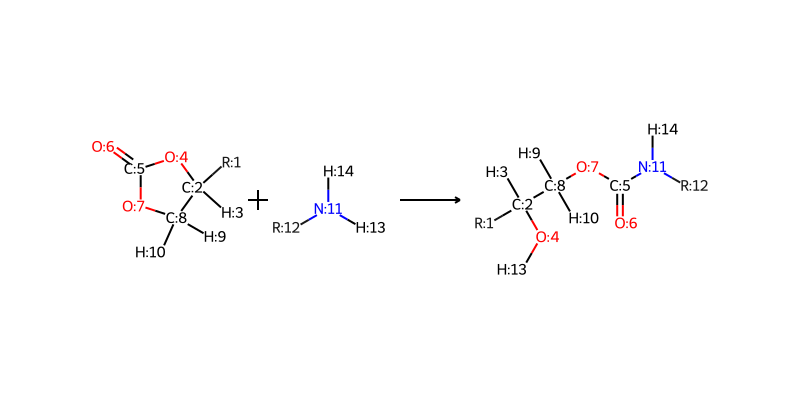

In [20]:
rxn = reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_PATH / f'{targ_rxn}.rxn')
rxn.Initialize()
num_warnings, num_errors = rxn.Validate()

print(num_warnings, num_errors)
display(rxn)

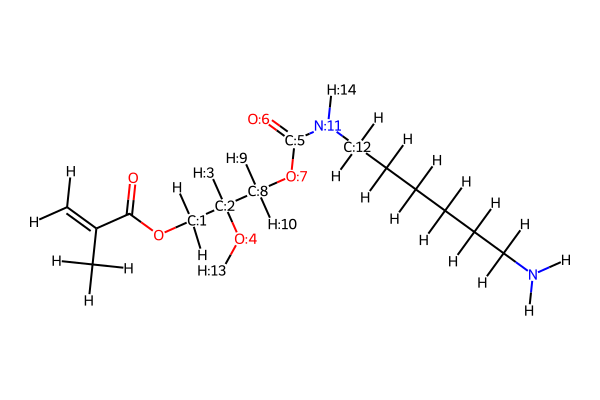

In [13]:
from polymerist.rdutils.reactions import reactors

reactor = reactors.PolymerizationReactor(rxn)
for product in reactor.react(reactants):
    display(product)

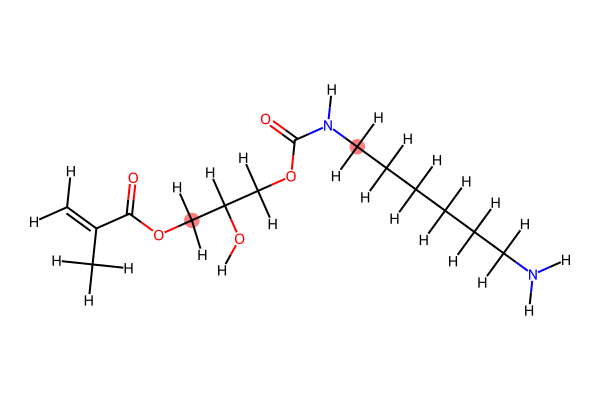

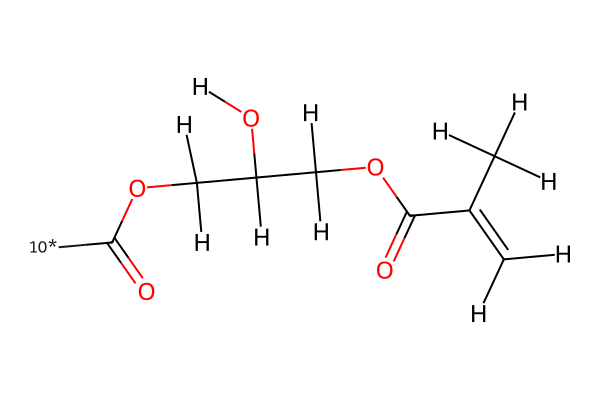

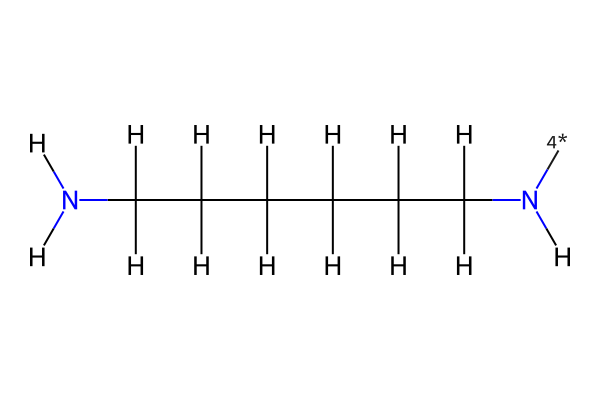

In [14]:
for intermeds, frags in reactor.propagate(reactants):
    for inter in intermeds:
        display(inter)

    for frag in frags:
        display(frag)
    print('='*50)